In [1]:
from visualiser import plot_ims
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline
import utils
from hlt import *
import math

In [41]:
with open('dumps/gameMap_smartfrontier_120','rb') as f:
    myID,gameMap = pickle.load(f)

In [18]:
def attractiveness(site):
    return (255.-site.strength)/255 + site.production/30.

def map_attractiveness(myID,gameMap):
    for y in range(gameMap.height):
        for x in range(gameMap.width):
            loc = Location(x,y)
            site = gameMap.getSite(loc)
            if site.owner == myID:
                site.attractiveness = -999
            else:
                site.attractiveness = attractiveness(site)
            site.potential_attr = site.attractiveness

def map_potential_attr(frontier,myID,gameMap,visited_set=None,decay=0.1):
    if not frontier:
        return
    if visited_set is None:
        visited_set = frontier
    new_frontier = set()
    for loc in frontier:
        site = gameMap.getSite(loc)
        for d in CARDINALS:
            new_loc = gameMap.getLocation(loc,d)
            new_site = gameMap.getSite(new_loc)
            if new_site.owner != myID or new_loc in visited_set:
                continue
            new_site.potential_attr = max(site.potential_attr-decay,new_site.potential_attr)
            new_frontier.add(new_loc)
    visited_set.update(new_frontier)
    map_potential_attr(new_frontier,myID,gameMap,visited_set=visited_set,decay=decay)

def attr_direction(loc,d,gameMap,momentumMap,momentumTerm=0.5):
    potential = gameMap.getSite(loc,d).potential_attr
    inv_d = utils.invert_direction(d)
    if d == momentumMap[loc]:
        momentum = momentumTerm
    elif inv_d == momentumMap[loc]:
        momentum = -momentumTerm
    else:
        momentum = 0.
    return potential + momentum

def map_directions(myID,gameMap,momentumMap,momentumTerm=0.5):
    for y in range(gameMap.height):
        for x in range(gameMap.width):
            loc = Location(x,y)
            site = gameMap.getSite(loc)
            if site.owner!=myID:
                site.direction=None
                site.potential_direction=None
                continue
            site.potential_direction = max(CARDINALS,key=lambda d:attr_direction(loc,d,gameMap,momentumMap,momentumTerm=0.))
            site.direction = max(CARDINALS,key=lambda d:attr_direction(loc,d,gameMap,momentumMap,momentumTerm=momentumTerm))

def adjust_frontier_potential(frontier,myID,gameMap,turn,enemy_attr=1.):
    for loc in frontier:
        site = gameMap.getSite(loc)
        for d in CARDINALS:
            newsite = gameMap.getSite(loc,d)
            if newsite.owner not in (0,myID):
                site.potential_attr += enemy_attr
                
def get_inner_frontier(frontier,myID,gameMap):
    inner_frontier = set()
    for loc in frontier:
        site = gameMap.getSite(loc)
        for d in CARDINALS:
            new_loc = gameMap.getLocation(loc,d)
            new_site = gameMap.getSite(new_loc)
            if new_site.owner != myID or new_loc in frontier:
                continue
            inner_frontier.add(new_loc)
            new_site.is_inner_frontier = True
    return inner_frontier

def smooth_inner_frontier(frontier,myID,gameMap):
    for loc in frontier:
        neighbors_potential_attr = [gameMap.getSite(loc,d).potential_attr for d in HALFCARDINALS if gameMap.getLocation(loc,d) in frontier]
        site = gameMap.getSite(loc)
        all_potentials = [site.potential_attr]+neighbors_potential_attr
        site.potential_attr_temp =  sum(all_potentials)/len(all_potentials)
    for loc in frontier:
        site = gameMap.getSite(loc)
        site.potential_attr =  site.potential_attr_temp

In [7]:
decay = 0.1
map_attractiveness(myID,gameMap)
frontier = utils.find_frontier(myID,gameMap)
map_potential_attr(set(frontier),myID,gameMap,decay=decay)
map_directions(myID,gameMap)

TypeError: map_directions() takes at least 3 arguments (2 given)

In [42]:
momentumMap = {Location(x,y):0 for x in range(gameMap.width) for y in range(gameMap.height)}

In [23]:
gameMap.getSite(Location(0,1)).potential_attr

1.0921568627450982

In [22]:
gameMap.getSite(Location(0,1))

site(owner=2,strength=19,prod=5)

In [17]:
(255-80)/255.

0.6862745098039216

In [39]:
loc = list(inner_frontier)[10]
site = gameMap.getSite(loc)
site.potential_attr_temp

-999

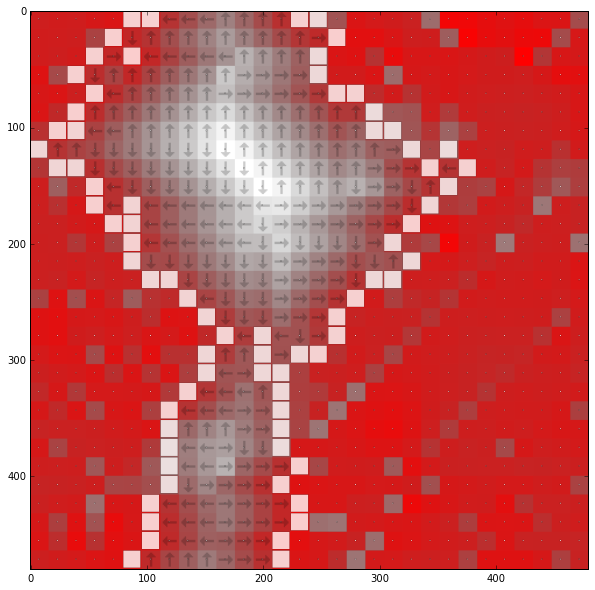

In [47]:
decay = 0.3
momentumTerm = 0.

#frontier = set(utils.frontier_tracking(frontier,myID,gameMap))
frontier = set(utils.find_frontier(myID,gameMap))

inner_frontier = get_inner_frontier(frontier,myID,gameMap)

map_attractiveness(myID,gameMap)

#adjust_frontier_potential(frontier,myID,gameMap,turn,enemy_attr=enemy_attr)

#smooth_inner_frontier(inner_frontier,myID,gameMap)
#smooth_inner_frontier(inner_frontier,myID,gameMap)
#smooth_inner_frontier(inner_frontier,myID,gameMap)
#smooth_inner_frontier(inner_frontier,myID,gameMap)

map_potential_attr(frontier,myID,gameMap,decay=decay)

#smooth_inner_frontier(inner_frontier,myID,gameMap)

#map_potential_attr(frontier,myID,gameMap,decay=decay)

map_directions(myID,gameMap,momentumMap,momentumTerm=momentumTerm)

state = {
    'size':'is_frontier',
    'arrows':'direction',
    'heat':'potential_attr'
}

plt.figure(figsize=(10,10))
_ = plot_ims(gameMap,state)

In [60]:
locsmap = {(x,y):Location(x,y) for x in range(gameMap.width) for y in range(gameMap.height)}

In [65]:
locsites = {loc:gameMap.getSite(loc) for loc in locsmap.values()}

In [72]:
locsites_d = {(loc,d):gameMap.getSite(loc,d) for loc in locsmap.values() for d in CARDINALS}

In [77]:
%timeit {(loc,d):gameMap.getSite(loc,d) for loc in locsmap.values() for d in CARDINALS}

10 loops, best of 3: 33.4 ms per loop


In [80]:
%timeit gameMap.getSite(loc)

The slowest run took 7.06 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 8.48 µs per loop


In [75]:
def attr_direction(loc,d,gameMap,momentumMap,momentumTerm=0.5):
    potential = locsites_d[(loc,d)].potential_attr
    inv_d = utils.invert_direction(d)
    # if d == momentumMap[loc]:
    #     momentum = momentumTerm
    if inv_d == momentumMap[loc]:
        momentum = -momentumTerm
    else:
        momentum = 0.
    return potential + momentum

def map_directions(myID,gameMap,momentumMap,momentumTerm=0.5):
    for y in range(gameMap.height):
        for x in range(gameMap.width):
            loc = locsmap[(x,y)]
            #loc = Location(x,y)
            #site = gameMap.getSite(loc)
            site = locsites[loc]
            if site.owner!=myID:
                site.direction=None
                #site.potential_direction=None
                continue
            # site.potential_direction = max(CARDINALS,key=lambda d:attr_direction(loc,d,gameMap,momentumMap,momentumTerm=0.))
            #momentum_d = momentumMap[loc]
            
            site.direction = max(CARDINALS,key=lambda d:attr_direction(loc,d,gameMap,momentumMap,momentumTerm=momentumTerm))

In [50]:
%timeit map_directions(myID,gameMap,momentumMap)

10 loops, best of 3: 20.2 ms per loop


In [52]:
%timeit map_directions(myID,gameMap,momentumMap)

100 loops, best of 3: 8.14 ms per loop


In [54]:
%timeit map_directions(myID,gameMap,momentumMap)

100 loops, best of 3: 8.22 ms per loop


In [56]:
%timeit map_directions(myID,gameMap,momentumMap)

The slowest run took 52.77 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 17.8 µs per loop


In [58]:
%timeit map_directions(myID,gameMap,momentumMap)

1000 loops, best of 3: 274 µs per loop


In [62]:
%timeit map_directions(myID,gameMap,momentumMap)

The slowest run took 8.07 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 87.2 µs per loop


In [64]:
%timeit map_directions(myID,gameMap,momentumMap)

100 loops, best of 3: 7.89 ms per loop


In [67]:
%timeit map_directions(myID,gameMap,momentumMap)

The slowest run took 6.02 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 377 µs per loop


In [69]:
%timeit map_directions(myID,gameMap,momentumMap)

The slowest run took 5.97 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 458 µs per loop


In [71]:
%timeit map_directions(myID,gameMap,momentumMap)

100 loops, best of 3: 12.3 ms per loop


In [76]:
%timeit map_directions(myID,gameMap,momentumMap)

100 loops, best of 3: 2.2 ms per loop
